# Zillow Prize Data Exploration

The objective of this competition is to estimate something called the **_logerror_**, which is the log of the ratio of the Zillow Zestimate of the sell price of a house and the actual sale price. We won't be given the actual Zestimate or price. The point is to figure out what sorts of sales Zillow is good at estimating, and what sort they are bad at estimating.

## Setup
Import useful packages for data analysis and plotting.

In [1]:
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(context = 'notebook', font_scale = 1.5, rc={'figure.figsize':(10, 6)})

from IPython.display import display #for displaying multiple outputs from a single cell

import datetime

import xgboost as xgb

import sklearn

/Users/stefan/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Import Data

Import the training data.

In [189]:
train_data = pd.read_csv('train_2016.csv')
print train_data.shape
train_data.head()

(90811, 3)


,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


We also import the property data, which has a lot of extra information about each property. Also, there are a lot more entries in the property data than in the training data (90811 rows vs 2985217 rows, almost 33 time more!). We will have to spend some time cleaning the data as well.

In [214]:
prop_data = pd.read_csv('properties_2016.csv')
print prop_data.shape
prop_data.head()

(2985217, 58)


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,10754147,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN,NaN,NaN
1,10759547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN,NaN,NaN
2,10843547,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN,NaN,NaN
3,10859147,NaN,NaN,NaN,0.0,0.0,3.0,7.0,NaN,NaN,...,1.0,NaN,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN,NaN,NaN
4,10879947,NaN,NaN,NaN,0.0,0.0,4.0,NaN,NaN,NaN,...,NaN,NaN,193796.0,433491.0,2015.0,239695.0,5725.17,NaN,NaN,NaN


## Clean Data

The data as given has many NaN entries. Most of them should actually be replaced with 0, but we will have to look more carefully to see what to do case-by-case. First, here is a list of all of the features together with the percentage that do not have NaN as the entry. We can see that there are many which are mostly NaN, but we can fix that. Also, we can see that _none_ of the features is present in 100% of the rows. That's just because we are given literally zero information about some of the properties in the dataset. If that bothers us in the future we can do something about it, but for now we will keep those rows around and just ignore them.

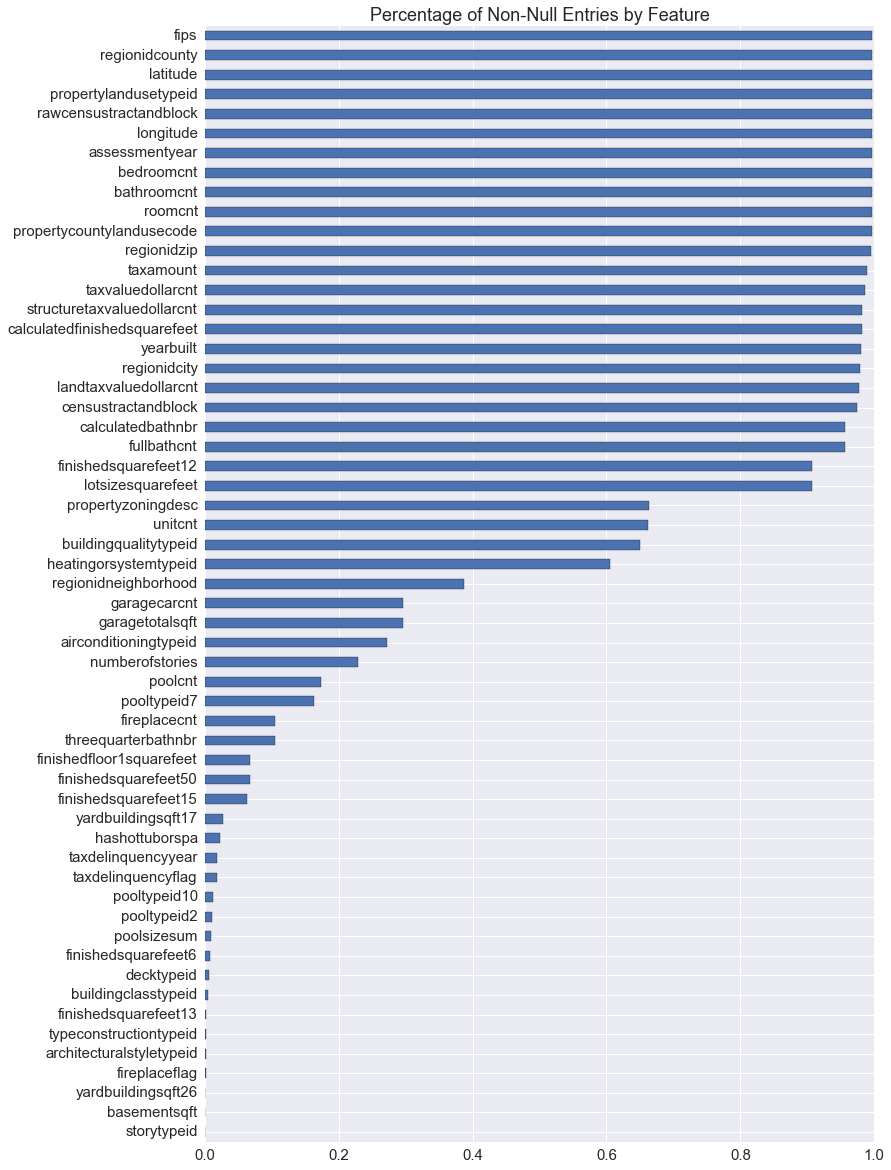

fips                            0.996169
regionidcounty                  0.996169
latitude                        0.996169
propertylandusetypeid           0.996169
rawcensustractandblock          0.996169
longitude                       0.996169
assessmentyear                  0.996168
bedroomcnt                      0.996164
bathroomcnt                     0.996160
roomcnt                         0.996156
propertycountylandusecode       0.995887
regionidzip                     0.995317
taxamount                       0.989532
taxvaluedollarcnt               0.985746
structuretaxvaluedollarcnt      0.981582
calculatedfinishedsquarefeet    0.981387
yearbuilt                       0.979925
regionidcity                    0.978948
landtaxvaluedollarcnt           0.977311
censustractandblock             0.974834
calculatedbathnbr               0.956817
fullbathcnt                     0.956817
finishedsquarefeet12            0.907533
lotsizesquarefeet               0.907511
propertyzoningde

In [215]:
with plt.rc_context({"figure.figsize": [12,20]}):
    prop_data.drop('parcelid',axis=1).notnull().mean().sort_values(ascending = True).plot(kind = 'barh')
plt.title('Percentage of Non-Null Entries by Feature')
plt.show()
prop_data.drop('parcelid',axis=1).notnull().mean().sort_values(ascending = False)

### Tax Delinquency

Some of the properties have delinquent taxes. Those that do have taxdelinqencyflag set to Y, the others have the flag set to NaN. We change Y to 1 and NaN to 0.

For those properties which have the tax delinquency flag set to 1, there is also a tax delinquency year. In the interest of avoiding NaN values, we will fill in the others to be in the year -99. Whether this is useful (or whether there is a better way to handle this) will depend on the model we choose to employ later.

In [165]:
prop_data.taxdelinquencyflag.fillna(0,inplace = True)
prop_data.taxdelinquencyflag.replace(to_replace = 'Y', value = 1,inplace = True)
prop_data.taxdelinquencyyear.fillna(-99,inplace = True)

### Pools, Hot Tubs, Spas

There are a few variables associatd with pools, hot tubs, and spas. poolcnt = NaN means there are no pools, and we will replace that designation with 0.

Those properties that do not have pools can have poolsizesum replaced by 0. Among those that do have pools, some have missing poolsizesum. We will use the median value as a replacement value among all properties with pools as the replacement value.

pooltypeid2 and pooltypeid7 are nonzero only when poolcnt is nonzero and indicate the type of pool that poolcnt refers to. They are a refienement of poolcnt, since poolcnt is the sum of the two. The NaN values of these can be filled by 0.

pooltypeid10 actually refers to hot tubs and spas. I don't know what the difference is between this variable and hashottuborspa, but they are not the same. pooltypeid10 is only nonzero when hottuborspa is True, but hashottuborspa has almost twice as many True entries as pooltypeid10 has nonzero entries. Since pooltypeid10 is only ever NaN or 1, I think it's just a redundant variable. I will probably not use it in my models as a result.

In [164]:
prop_data.poolcnt.fillna(0,inplace = True)
prop_data.ix[prop_data.poolcnt==1, 'poolsizesum']=\
    prop_data.ix[prop_data.poolcnt==1, 'poolsizesum'].fillna(prop_data[prop_data.poolcnt==1].poolsizesum.median())
prop_data.ix[prop_data.poolcnt==0, 'poolsizesum']=0
prop_data.pooltypeid2.fillna(0,inplace = True)
prop_data.pooltypeid7.fillna(0,inplace = True)
prop_data.pooltypeid10.fillna(0,inplace = True)
prop_data.hashottuborspa.fillna(0,inplace = True)
prop_data.hashottuborspa.replace(to_replace = True, value = 1,inplace = True)

### Garages

We have two variables associated with garages. garagecarcnt tells us the number of garages and garagetotalsqft is the total square footage of the garages. Both can have their NaN filled with 0.

One would expect that garagecarcnt = 0 if and only if garagetotalsqft =0. This does not appear to be the case, but the number of anomalous cases is very small so we will choose to ignore it for now

In [163]:
prop_data.garagecarcnt.fillna(0,inplace = True)
prop_data.garagetotalsqft.fillna(0,inplace = True)

### Fireplaces

fireplacecnt counts the number of fireplaces, and fireplaceflag = True indicates at least one fireplace. In the original data, these two columns are not serving their stated purpose. Perhaps because of some inconsistent data gathering, it seems that fireplaceflag and fireplacecnt were used independently of each other. We can fix this in a few steps.

First, when firesideflag=True we need to fill in the number of fireplaces. We fill in using the median number of fireplaces for the remainder of the data (which is 1 fireplace).

Then everywhere the fireplacecnt is not null, we switch fireplaceflag to True (because null is a stand-in for zero).

Finally, we fillna on both features with 0, and replace True with 1 because we prefer numerical values.

After cleaning, fireplacecnt provides strictly more information that fireplaceflag.

In [166]:
prop_data.ix[prop_data.fireplaceflag==True, 'fireplacecnt']=\
    prop_data.ix[prop_data.fireplaceflag==True, 'fireplacecnt'].fillna(1) #1 is the median number of fireplaces
prop_data.ix[prop_data.fireplacecnt.notnull(),'fireplaceflag'] = True
prop_data.fireplacecnt.fillna(0,inplace = True)
prop_data.fireplaceflag.fillna(0,inplace = True)
prop_data.fireplaceflag.replace(to_replace = True, value = 1,inplace = True)

### Tax Value and Assessed Taxes

landtaxvaluedollarcnt and structuretaxvaluedollarcnt are the land and structure assessed values, resepectively, for the purposes of taxes. taxvaluedollarcnt is simply the sum of those two columns, whether or not there is data missing.

taxamount is is the total property tax assessed for a single year (the specific year is given in assessmentyear, though this data is incomplete). We can take the ratio of the taxamount and taxvaluedollarcnt to get an effective tax rate. We expect this rate to be of the order of 1%, and in fact the median tax rate is about 1.3%. However, there are a few outliers and the calculated taxrate is sometimes very large (hundreds of times the listed price of the property). Some of this can be attributed to missing structure/land values, but in the worst cases is probably due to inaccuracies in the property values.

UNFINISHED SECTION

In [167]:
prop_data['taxrate'] = prop_data['taxamount']/prop_data['taxvaluedollarcnt']
prop_data['taxrate'].median()

0.012690279172292812

In [146]:
prop_data[prop_data.taxamount.notnull()].taxvaluedollarcnt.isnull().sum()

23902

In [145]:
prop_data[prop_data.taxamount.notnull()].taxvaluedollarcnt.isnull().describe()

count     2953967
unique          2
top         False
freq      2930065
Name: taxvaluedollarcnt, dtype: object

### Fill remaining data

There are some other categories that we will fillna using obvious values.

In [168]:
prop_data.assessmentyear.fillna(prop_data.assessmentyear.median,inplace = True)

## Basic Statistics

We merge our property data into the training data, effectively adding the columns from the property data to the training data to help with our predictions.

In [190]:
train_data = train_data.merge(prop_data, how = 'left')

The month of the transaction is also important for our predictions, so we add a column representing the month.

In [191]:
train_data.transactiondate=train_data.transactiondate.apply(lambda x: datetime.datetime.strptime(str(x),'%Y-%m-%d'))
train_data['month'] =train_data['transactiondate'].apply(lambda x: x.month)
train_data.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,taxrate,month
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,122754.0,360170.0,2015,237416.0,6735.88,0,-99.0,6.037107e+13,0.018702,1
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,346458.0,585529.0,2015,239071.0,10153.02,0,-99.0,NaN,0.017340,1
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,61994.0,119906.0,2015,57912.0,11484.48,0,-99.0,6.037464e+13,0.095779,1
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,171518.0,244880.0,2015,73362.0,3048.74,0,-99.0,6.037296e+13,0.012450,1
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,169574.0,434551.0,2015,264977.0,5488.96,0,-99.0,6.059042e+13,0.012631,1


First we will look at the overall distribution of logerror:

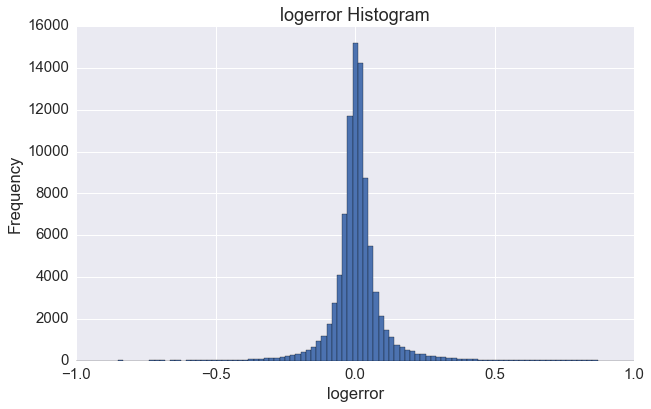

In [80]:
train_data.hist('logerror',bins=500)

#Change the labels of the axes and title
plt.title('logerror Histogram')
plt.xlabel('logerror')
plt.ylabel('Frequency')
plt.axis([-1,1,0,16000])

#Explicitly entering the show command gives cleaner output.
plt.show()

The logerrors are mostly quite small. The plot skews slightly positive, as we can see with the following calculations:

In [201]:
print 'The mean logerror is {:f}.'.format(train_data['logerror'].mean())
print 'The median logerror is {:f}.'.format(train_data['logerror'].median())
print 'The standard deviation of the logerror is {:f}.'.format(train_data['logerror'].std())

The mean logerror is 0.010816.
The median logerror is 0.005000.
The standard deviation of the logerror is 0.163288.


## Logerror Over Time

The month of the year has a large effect on mean the logerror, as we can see by the following plot:

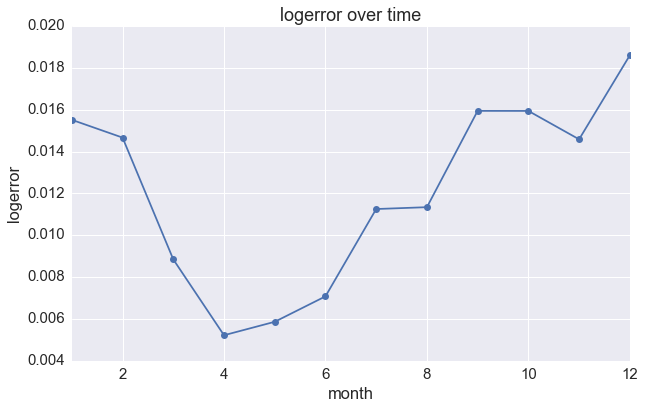

In [212]:
train_data[['logerror','month']].groupby('month').mean().plot(marker='o', legend=False)
plt.title('logerror over time')
plt.ylabel('logerror')
plt.show()

The first thing to note about this plot is that the average logerror is _positive_ for every month. So there seems to be a systematic overestimate of the selling price. The logerror seems to drop in the spring months, and get larger in the fall and winter. This is a bit surprising because one would expect the logerror to get smaller as time goes on.

We can get more information about this by plotting the standard deviation of the logerror:

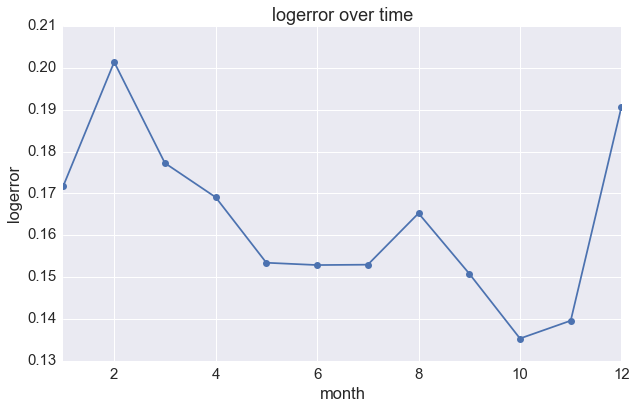

In [92]:
train_data[['logerror','month']].groupby('month').std().plot(marker='o', legend=False)
plt.title('logerror standard deviation over time')
plt.ylabel('logerror std')
plt.show()

Except for the final month, the standard deviation mostly goes down wiht time. This is perhaps attributable to the algorithm getting more precise with time.

A more fine-grained moving average is obtained by not grouping by month first. We take all of the transactions for the year in transaction-date order and compute a rolling-window mean and standard deviation of 20,000 transactions.

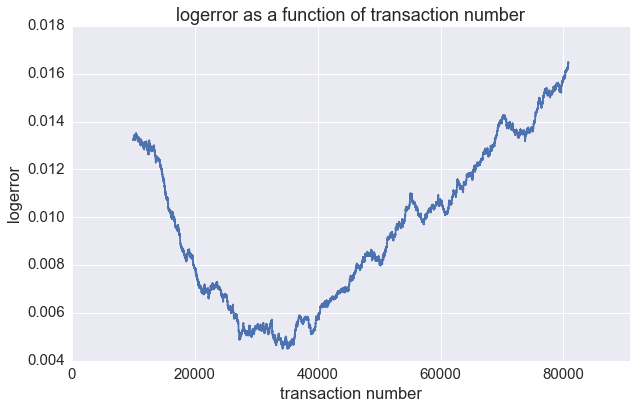

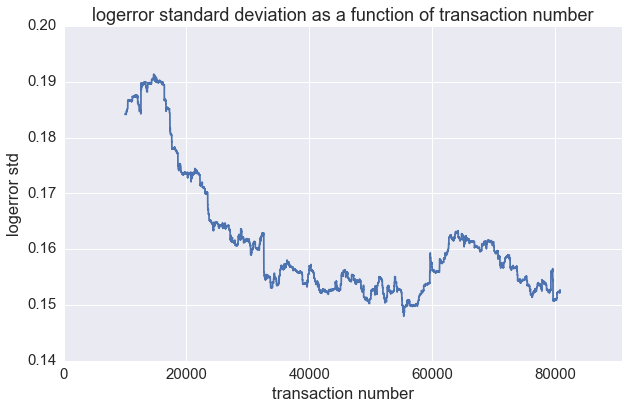

In [495]:
train_data.logerror.rolling(window=20000, center=True).mean().plot(legend=False)
plt.title('logerror as a function of transaction number')
plt.ylabel('logerror')
plt.xlabel('transaction number')
plt.show()
plt.show()
train_data.logerror.rolling(window=20000, center=True).std().plot(legend=False)
plt.title('logerror standard deviation as a function of transaction number')
plt.ylabel('logerror std')
plt.xlabel('transaction number')
plt.show()
plt.show()

The story here is similar as with the data collected per month. The shrinking standard deviation suggests that the algorithm is becoming more precise with time. However, the mean does _not_ shrink monotonically with time. With the data available, we cannot distinguish seasonal or other transitory effects from changes in the algorithm. It's also noteworthy that the rolling mean logerror never drops below zero.

## Location Statistics

Houses and apartments in similar neighborhoods are often similar to each other, and so we might expect high correlation between the logerror and the location. We begin by plotting all locations of the properties sold. The result looks like a portion of a map of Los Angeles:

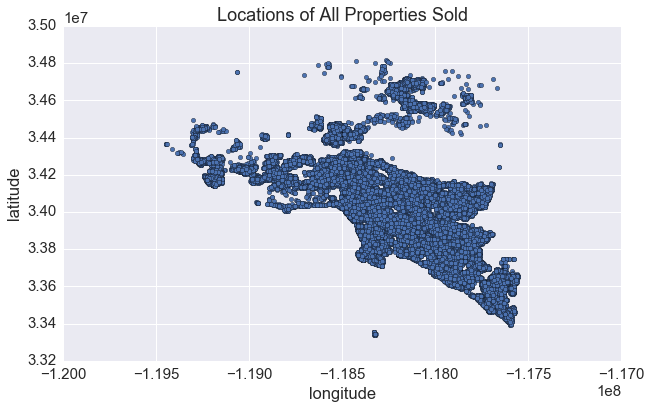

In [397]:
train_data.plot(x='longitude',y='latitude', kind='scatter')
plt.title('Locations of All Properties Sold')
plt.show()

## Feature Importance Using XGBoost

XGBoost has a nice built-in function that helps us gauge what the most important features are for determining the logerror. So we can make a quick XGBoost model and read off the important features as follows:

In [195]:
X = train_data.drop(['logerror','parcelid','transactiondate', 'propertycountylandusecode',\
                     'propertyzoningdesc','assessmentyear'],axis=1)
Y = train_data['logerror']
features = X.columns

X_train, X_cv, Y_train, Y_cv = sklearn.model_selection.train_test_split(X,Y,test_size=0.2)

dtrain = xgb.DMatrix(X_train,label = Y_train)
dcv = xgb.DMatrix(X_cv,label = Y_cv)

#mae = mean absolute error
#eta = learning rate
#lambda = L2 regulator
params = {'objective':'reg:linear','eval_metric':'mae','eta':0.1,'max_depth':4, 'lambda':2}
watchlist = [(dtrain, 'train'), (dcv, 'cv')]

bst = xgb.train(params, dtrain, 400, watchlist, verbose_eval=50)

[0]	train-mae:0.449562	cv-mae:0.450375
[50]	train-mae:0.068503	cv-mae:0.069876
[100]	train-mae:0.067901	cv-mae:0.069887
[150]	train-mae:0.067582	cv-mae:0.070072
[200]	train-mae:0.067298	cv-mae:0.070213
[250]	train-mae:0.067057	cv-mae:0.070408
[300]	train-mae:0.066805	cv-mae:0.07057
[350]	train-mae:0.066586	cv-mae:0.07074
[399]	train-mae:0.066346	cv-mae:0.070913


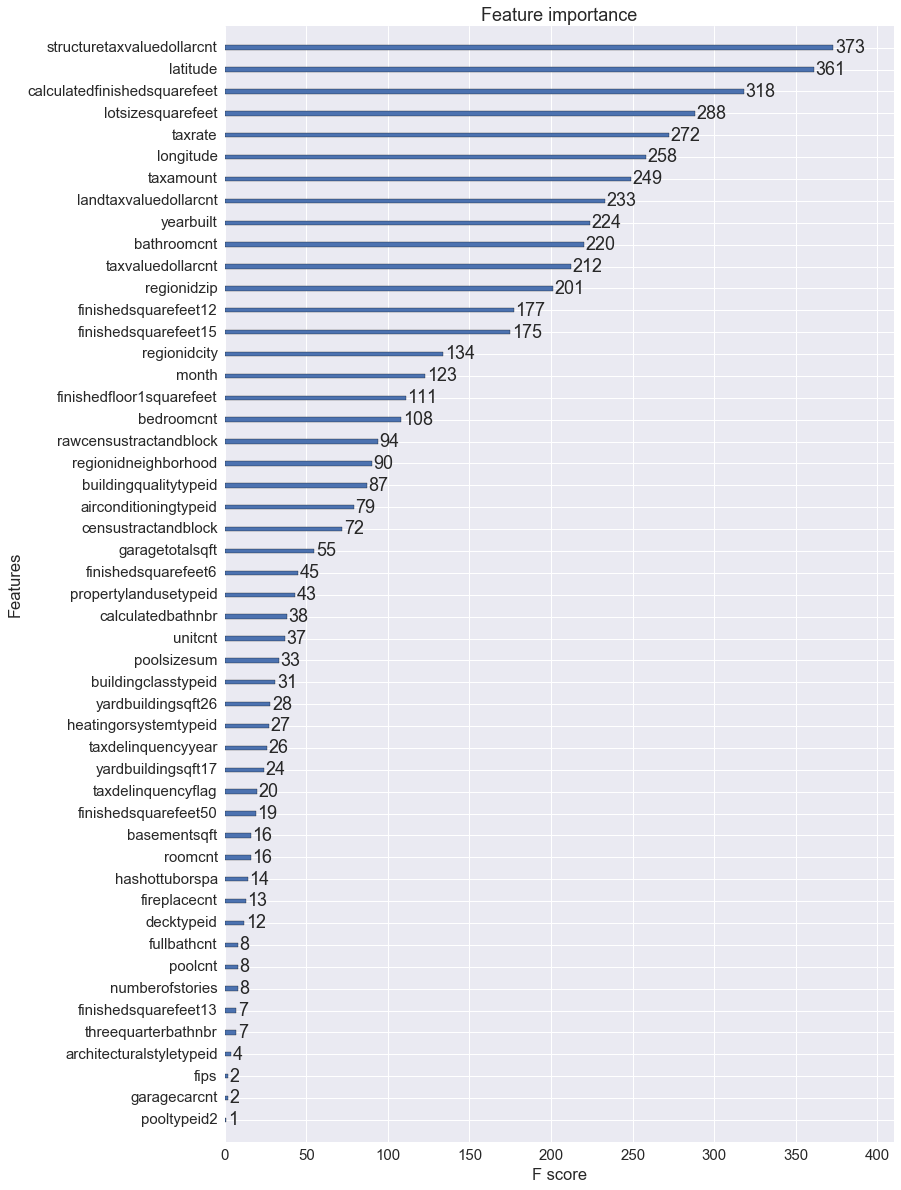

In [196]:
with plt.rc_context({"figure.figsize": [12,20]}):
    xgb.plot_importance(bst)
plt.show()

## Generate Prediction

Not really ready for this yet, but wanted to test it out to make sure I had the submission format right.

In [197]:
def generate_prediction():
    preds = pd.DataFrame(0, index=np.arange(2985217), columns=['ParcelId'])
    preds.ParcelId = prop_data.parcelid
    X_test = prop_data.drop(['parcelid', 'propertycountylandusecode',\
                     'propertyzoningdesc','assessmentyear'],axis=1)
    for m in range(10,13):
        X_test['month']= m 
        X_test= X_test[features]
        dtest = xgb.DMatrix(X_test)
        errors = bst.predict(dtest)
        preds['2016{}'.format(m)] = errors
        preds['2017{}'.format(m)] = errors
    
    return preds

In [264]:
preds = generate_prediction()
preds.head()

,ParcelId,201610,201710,201611,201711,201612,201712
0,10754147,0.188416,0.188416,0.188416,0.188416,0.188416,0.188416
1,10759547,-0.086102,-0.086102,-0.086102,-0.086102,-0.086102,-0.086102
2,10843547,0.210335,0.210335,0.210335,0.210335,0.210335,0.210335
3,10859147,0.668599,0.668599,0.668599,0.668599,0.668599,0.668599
4,10879947,0.320769,0.320769,0.320769,0.320769,0.320769,0.320769


In [210]:
#Save predictions to csv file for submission.
#preds.to_csv('All005.csv', index=False,float_format='%.4f')